In [4]:
pip install PyPDF2 transformers torch matplotlib nltk pandas

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/belleschall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/belleschall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Most common words in MSFT - Q3 2024 Earnings Call 25April2024 530 PM ET CORRECTED TRANSCRIPT - 25-Apr-24.pdf:
[('microsoft', 75), ('ai', 72), ('growth', 61), ('revenue', 59), ('llc', 47), ('azure', 45), ('copilot', 43), ('business', 41), ('call', 40), ('think', 39)]
Positive words in MSFT - Q3 2024 Earnings Call 25April2024 530 PM ET CORRECTED TRANSCRIPT - 25-Apr-24.pdf: {'like', 'easier', 'focused', 'trust', 'superior', 'good', 'acceptance', 'strengthening', 'safety', 'success', 'advanced', 'played', 'interest', 'improvement', 'vision', 'fitness', 'loves', 'ly', 'opportunities', 'solutions', 'value', 'parties', 'capable', 'fine', 'love', 'loyalists', 'accepted', 'opportunity', 'care', 'efficiencies', 'fantastic', 'gains', 'profits', 'outstanding', 'best', 'special', 'healthy', 'playing', 'optimization', 'strong', 'helpful', 'interesting', 'ability', 'successfully', 'excited', 'wells', 'sophisticated', 'congrats', 'secure', 'successful', 'strength', 'want', 'pretty', 'free', 'progress

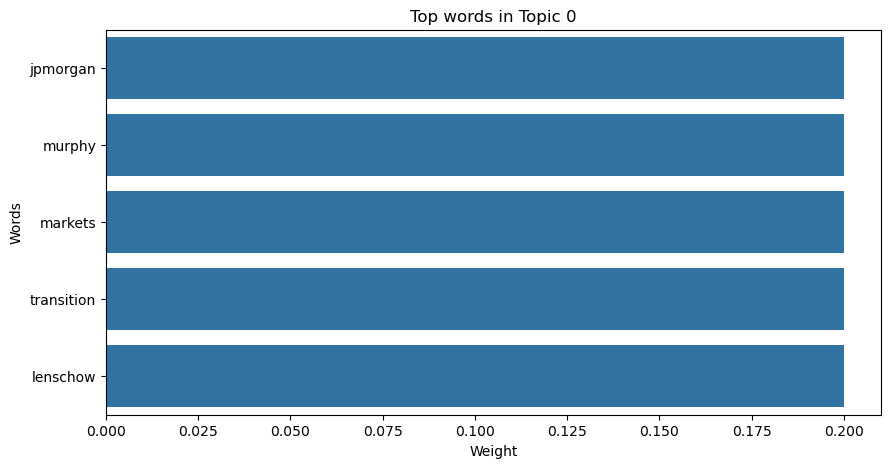

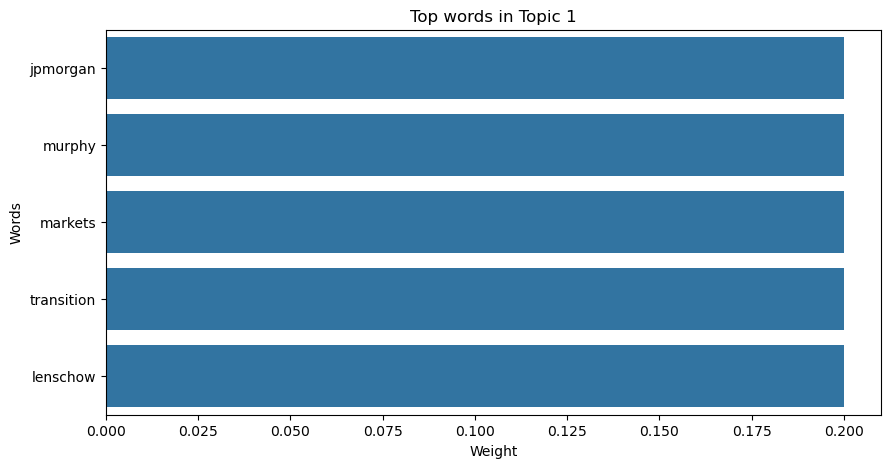

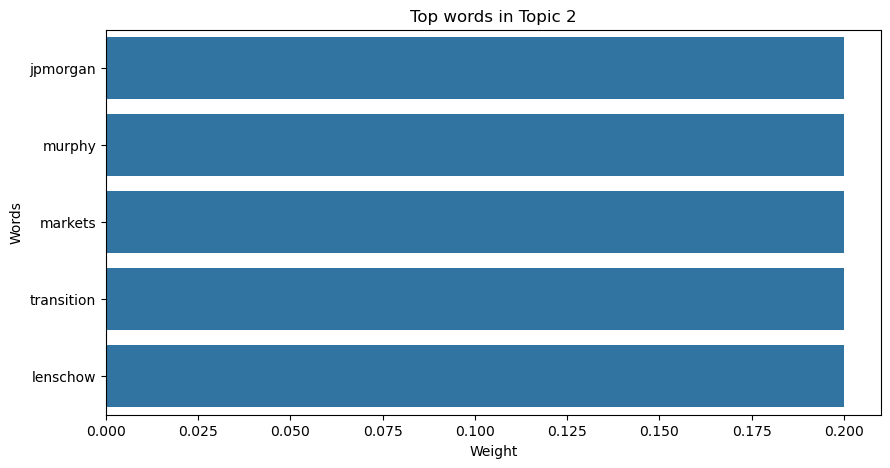

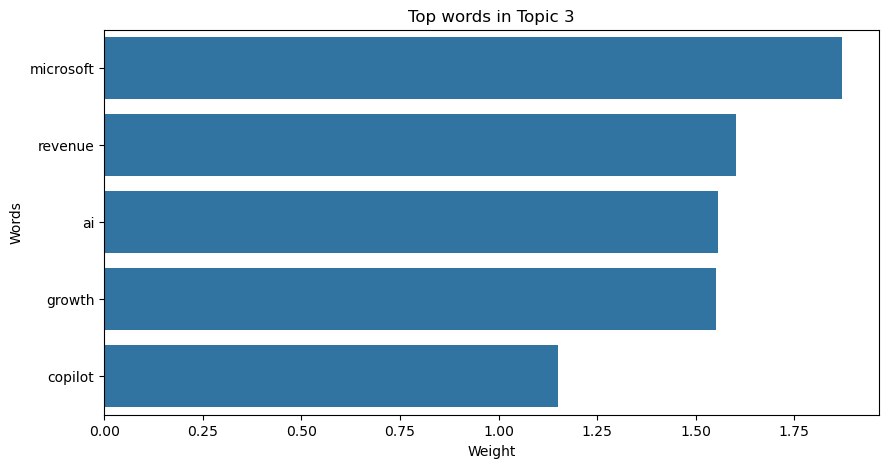

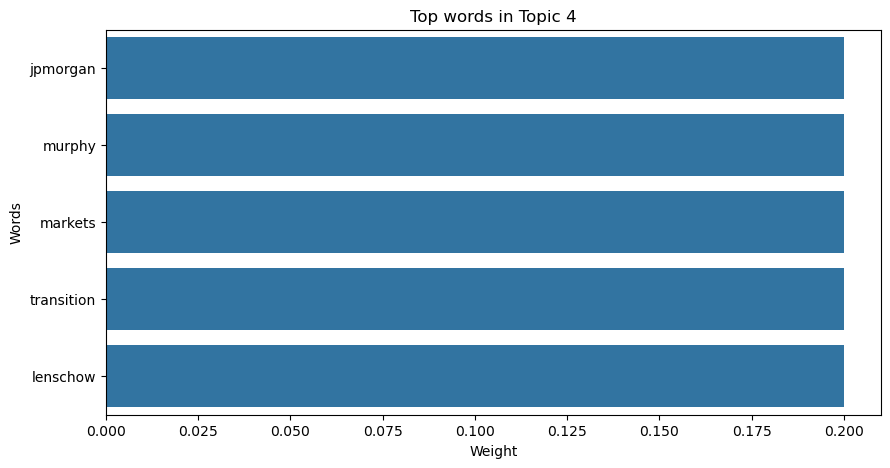

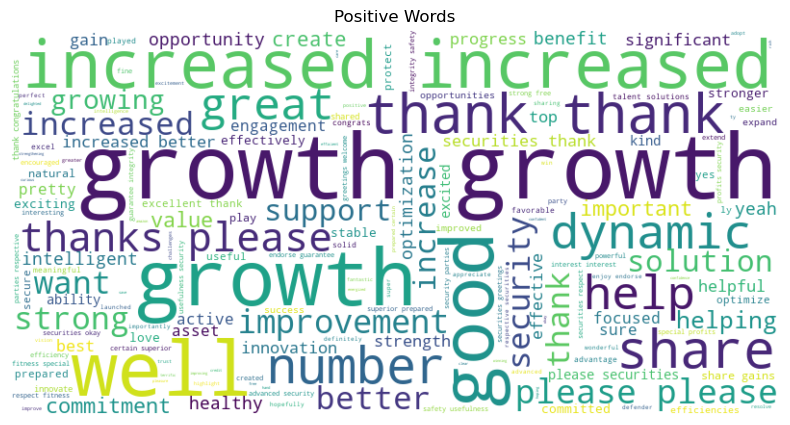

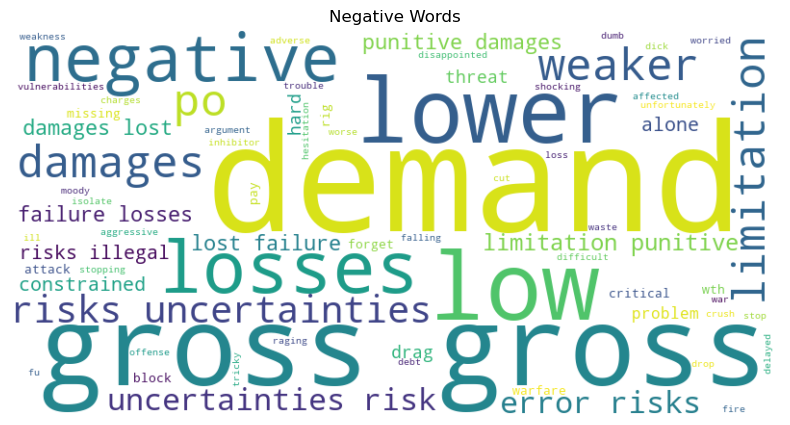


Topic distribution for each document:
Document 1: [0.01081756 0.01081756 0.01081756 0.95672977 0.01081756]
Document 2: [0.01061925 0.01061925 0.01061925 0.95752299 0.01061925]
Document 3: [0.01087651 0.01087651 0.01087651 0.95649396 0.01087651]
Document 4: [0.01083499 0.01083499 0.01083499 0.95666003 0.01083499]
Document 5: [0.01080008 0.01080008 0.01080008 0.95679966 0.01080008]
Document 6: [0.01088583 0.01088583 0.01088583 0.95645667 0.01088583]


In [8]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
import PyPDF2

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

# Function to extract text from a PDF file (using PyPDF2)
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Preprocess the text for analysis
def preprocess_text(text):
    """Preprocess the text for analysis."""
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

# Function to perform topic modeling using LDA from sklearn
def perform_topic_modeling(documents, num_topics=5):
    """Performs LDA topic modeling on the given list of documents."""
    # Convert documents to a single string
    documents = [" ".join(doc) for doc in documents]

    # Convert the documents into TF-IDF features
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Apply Latent Dirichlet Allocation (LDA)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)

    return lda, vectorizer

# Function to report topics and their top words
def report_topics(lda_model, vectorizer, num_words=5):
    """Reports the topics, their weights, and top words in each topic."""
    feature_names = vectorizer.get_feature_names_out()
    topics_info = []
    for idx, topic in enumerate(lda_model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topic_weights = topic[topic.argsort()[:-num_words - 1:-1]]
        topics_info.append((idx, topic_words, topic_weights))
    return topics_info

# Analyze sentiment of the tokens
def analyze_sentiment(tokens):
    """Analyze sentiment of the tokens and return positive and negative words."""
    sia = SentimentIntensityAnalyzer()
    positive_words = []
    negative_words = []

    for word in tokens:
        sentiment_score = sia.polarity_scores(word)
        if sentiment_score['compound'] > 0.05:  # positive sentiment threshold
            positive_words.append(word)
        elif sentiment_score['compound'] < -0.05:  # negative sentiment threshold
            negative_words.append(word)

    return positive_words, negative_words

# Function to plot top words for each topic
def plot_topics(lda_model, vectorizer, num_words=5):
    """Plots the top words for each topic."""
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        weights = topic[topic.argsort()[:-num_words - 1:-1]]
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=weights, y=words)
        plt.title(f'Top words in Topic {idx}')
        plt.xlabel('Weight')
        plt.ylabel('Words')
        plt.show()

# Function to plot wordcloud for positive/negative words
def plot_wordcloud(words, title):
    """Plots a word cloud for the given words."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Main function
def main():
    # Path to the directory containing your earnings call PDF files
    pdf_directory = "/Users/belleschall/Desktop/finance/MSFT"

    documents = []
    positive_words = []
    negative_words = []
    for filename in os.listdir(pdf_directory):
        if filename.endswith(".pdf"):
            pdf_file_path = os.path.join(pdf_directory, filename)
            
            # Extract text from PDF
            text = extract_text_from_pdf(pdf_file_path)

            # Preprocess and analyze the text
            tokens = preprocess_text(text)
            documents.append(tokens)

            # Print most common words for the current file
            freq_dist = FreqDist(tokens)
            print(f"\nMost common words in {filename}:")
            print(freq_dist.most_common(10))

            # Analyze sentiment and report positive and negative words
            pos_words, neg_words = analyze_sentiment(tokens)
            positive_words.extend(pos_words)
            negative_words.extend(neg_words)
            print(f"Positive words in {filename}: {set(pos_words)}")
            print(f"Negative words in {filename}: {set(neg_words)}")

    # Perform topic modeling on all documents using LDA (scikit-learn)
    lda_model, vectorizer = perform_topic_modeling(documents)

    # Report the topics and their weights
    print("\nTopics found by LDA:")
    topics_info = report_topics(lda_model, vectorizer)
    for idx, topic_words, topic_weights in topics_info:
        print(f"Topic {idx}: {', '.join(topic_words)}")

    # Plot top words for each topic
    plot_topics(lda_model, vectorizer)

    # Plot word clouds for positive and negative words
    plot_wordcloud(positive_words, 'Positive Words')
    plot_wordcloud(negative_words, 'Negative Words')

    # Report the topic distribution for each document
    print("\nTopic distribution for each document:")
    documents_matrix = vectorizer.transform([" ".join(doc) for doc in documents])
    topic_distribution = lda_model.transform(documents_matrix)
    for i, distribution in enumerate(topic_distribution):
        print(f"Document {i + 1}: {distribution}")

# Run the main function
if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/belleschall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use mps:0


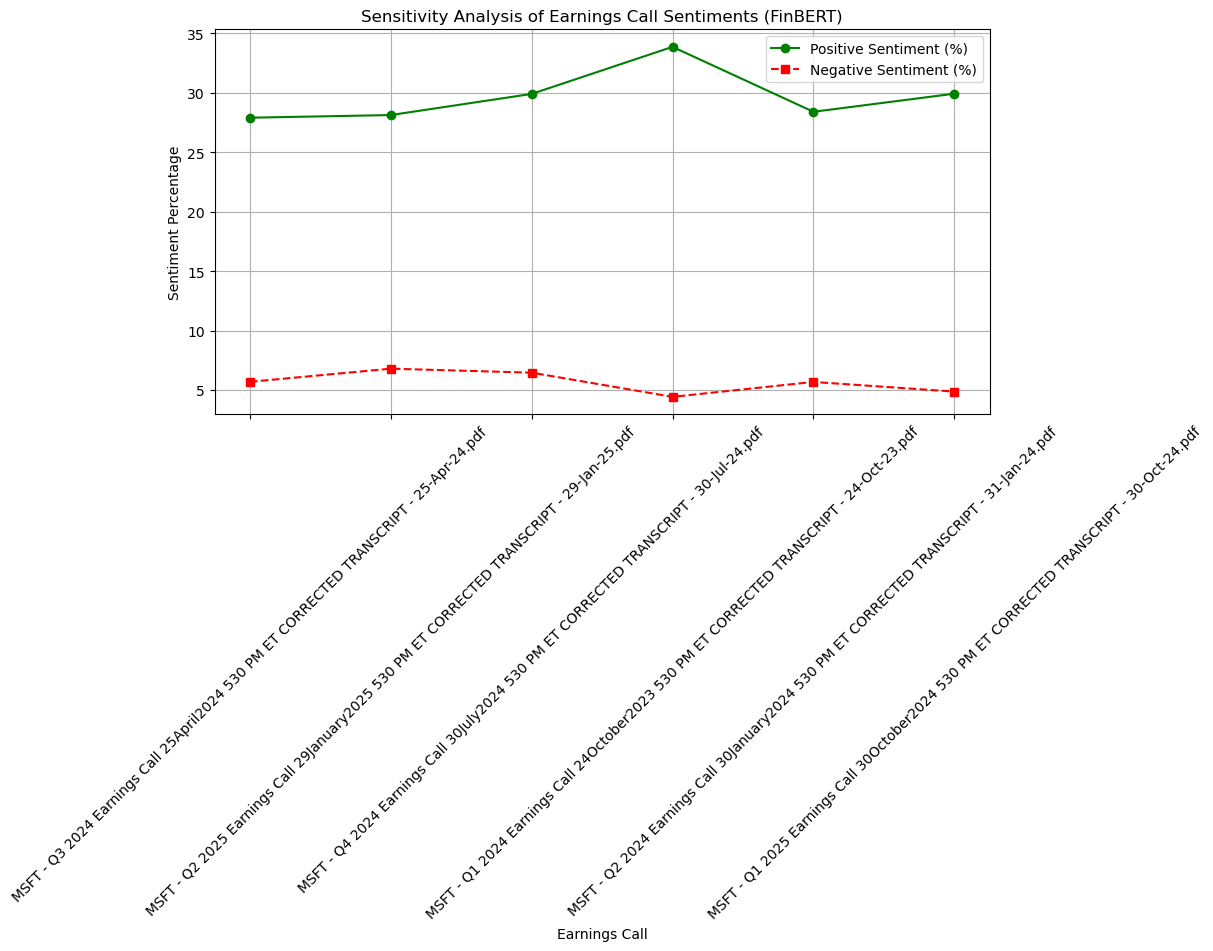

                                       Earnings Call  Positive  Neutral  \
0  MSFT - Q3 2024 Earnings Call 25April2024 530 P...       152      362   
1  MSFT - Q2 2025 Earnings Call 29January2025 530...       149      345   
2  MSFT - Q4 2024 Earnings Call 30July2024 530 PM...       162      345   
3  MSFT - Q1 2024 Earnings Call 24October2023 530...       176      321   
4  MSFT - Q2 2024 Earnings Call 30January2024 530...       155      360   
5  MSFT - Q1 2025 Earnings Call 30October2024 530...       166      362   

   Negative  Total Sentences  Positive %  Negative %  
0        31              545   27.889908    5.688073  
1        36              530   28.113208    6.792453  
2        35              542   29.889299    6.457565  
3        23              520   33.846154    4.423077  
4        31              546   28.388278    5.677656  
5        27              555   29.909910    4.864865  


In [12]:
import os
import PyPDF2
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline

# Download NLTK tokenizer (if not already installed)
nltk.download("punkt")

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

# Folder containing earnings call PDFs
folder_path = "/Users/belleschall/Desktop/finance/MSFT"

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Function to process sentences safely (truncate if >512 tokens)
def analyze_text_with_truncation(text):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=512, return_tensors="pt")
    sentiment = sentiment_pipeline(text[:512])[0]  # Only send 512 chars to avoid token mismatch
    return sentiment

# Process each PDF in the folder
sentiment_results = []
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        file_path = os.path.join(folder_path, filename)
        
        # Extract text from PDF
        transcript_text = extract_text_from_pdf(file_path)
        sentences = sent_tokenize(transcript_text)

        # Run sentiment analysis with truncation
        sentiments = [analyze_text_with_truncation(sentence) for sentence in sentences]

        # Count sentiment distribution
        sentiment_counts = {
            "positive": sum(1 for s in sentiments if s["label"] == "positive"),
            "neutral": sum(1 for s in sentiments if s["label"] == "neutral"),
            "negative": sum(1 for s in sentiments if s["label"] == "negative")
        }
        
        # Store results
        sentiment_results.append({
            "Earnings Call": filename,
            "Positive": sentiment_counts["positive"],
            "Neutral": sentiment_counts["neutral"],
            "Negative": sentiment_counts["negative"],
            "Total Sentences": len(sentiments),
            "Positive %": sentiment_counts["positive"] / len(sentiments) * 100,
            "Negative %": sentiment_counts["negative"] / len(sentiments) * 100
        })

# Convert results to DataFrame
df_results = pd.DataFrame(sentiment_results)

# 🎨 Plot sensitivity analysis (Positive vs. Negative %)
plt.figure(figsize=(10, 5))
plt.plot(df_results["Earnings Call"], df_results["Positive %"], marker="o", linestyle="-", label="Positive Sentiment (%)", color="green")
plt.plot(df_results["Earnings Call"], df_results["Negative %"], marker="s", linestyle="--", label="Negative Sentiment (%)", color="red")
plt.xlabel("Earnings Call")
plt.ylabel("Sentiment Percentage")
plt.title("Sensitivity Analysis of Earnings Call Sentiments (FinBERT)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# 📊 Print summarized sensitivity results
print(df_results)

In [48]:
import yfinance as yf
import pandas as pd
from datetime import timedelta

# Function to get stock data for the earnings call date and the next day
def get_stock_data_for_earnings(ticker, earnings_date):
    # Calculate the date range to fetch stock data (one day before and one day after)
    earnings_date_obj = pd.to_datetime(earnings_date)
    start_date = earnings_date_obj - timedelta(days=1)  # One day before the earnings call
    end_date = earnings_date_obj + timedelta(days=1)    # One day after the earnings call

    # Fetch stock data for the date range
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    return stock_data

# Function to calculate the 1-day return
def calculate_1_day_return(stock_data):
    if len(stock_data) < 2:
        return None  # Not enough data to calculate return

    # Get the close prices for the two days
    close_on_day_1 = stock_data['Close'].iloc[0]  # Earnings call day (Day 1)
    close_on_day_2 = stock_data['Close'].iloc[-1]  # Next day (Day 2)

    # Calculate the return
    return_percentage = ((close_on_day_2 - close_on_day_1) / close_on_day_1) * 100
    
    # Return the calculated percentage as a float (to avoid Series issues)
    return return_percentage.item() if isinstance(return_percentage, pd.Series) else return_percentage

# Example earnings call dates (modify as needed)
earnings_call_dates = ['2024-04-25', '2025-01-29', '2024-07-30', '2023-10-24', '2024-01-30', '2024-10-30']

# Loop through each earnings call date and fetch data
for earnings_date in earnings_call_dates:
    stock_data = get_stock_data_for_earnings('MSFT', earnings_date)
    if stock_data is not None and len(stock_data) >= 2:
        return_percentage = calculate_1_day_return(stock_data)
        if return_percentage is not None:
            print(f"Earnings Call on {earnings_date}: {return_percentage:.2f}% return")
        else:
            print(f"Earnings Call on {earnings_date}: Not enough data to calculate return")
    else:
        print(f"Earnings Call on {earnings_date}: Not enough data available")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Earnings Call on 2024-04-25: -2.45% return
Earnings Call on 2025-01-29: -1.09% return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Earnings Call on 2024-07-30: -0.89% return
Earnings Call on 2023-10-24: 0.37% return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Earnings Call on 2024-01-30: -0.28% return
Earnings Call on 2024-10-30: 0.13% return


In [72]:
sentiment_data = {
    'positive_sentiment': [176, 155, 152, 162, 149, 166],
    'negative_sentiment': [23, 31, 31, 35, 36, 27],
    'stock_1day_return': [-2.45, -1.09, -0.89, 0.37, -0.28, 0.13],
    'quarter': ['Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025', 'Q2 2025'],
    'year': [2024, 2024, 2024, 2024, 2025, 2025]
}

import pandas as pd

# Sentiment data (example)
sentiment_data = {
    'positive_sentiment': [176, 155, 152, 162, 149, 166],
    'negative_sentiment': [23, 31, 31, 35, 36, 27],
    'stock_1day_return': [-2.45, -1.09, -0.89, 0.37, -0.28, 0.13],
    'quarter': ['Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025', 'Q2 2025'],
    'year': [2024, 2024, 2024, 2024, 2025, 2025]
}

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_data)
print(sentiment_df)

# Calculate correlation between positive sentiment, neutral sentiment, and stock returns
correlation_positive = sentiment_df['positive_sentiment'].corr(sentiment_df['stock_1day_return'])
correlation_neutral = sentiment_df['negative_sentiment'].corr(sentiment_df['stock_1day_return'])

print(f"Correlation between positive sentiment and stock returns: {correlation_positive:.2f}")
print(f"Correlation between neutral sentiment and stock returns: {correlation_neutral:.2f}")

   positive_sentiment  negative_sentiment  stock_1day_return  quarter  year
0                 176                  23              -2.45  Q1 2024  2024
1                 155                  31              -1.09  Q2 2024  2024
2                 152                  31              -0.89  Q3 2024  2024
3                 162                  35               0.37  Q4 2024  2024
4                 149                  36              -0.28  Q1 2025  2025
5                 166                  27               0.13  Q2 2025  2025
Correlation between positive sentiment and stock returns: -0.43
Correlation between neutral sentiment and stock returns: 0.68


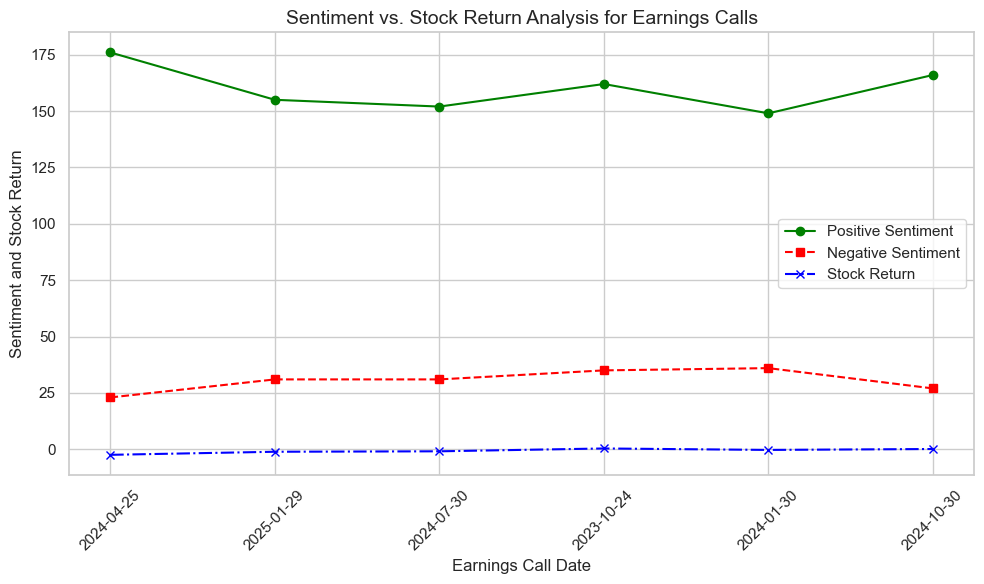

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sentiment data (example from previous discussion)
sentiment_data = {
    'positive_sentiment': [176, 155, 152, 162, 149, 166],
    'negative_sentiment': [23, 31, 31, 35, 36, 27],  # Example negative sentiment data
    'stock_1day_return': [-2.45, -1.09, -0.89, 0.37, -0.28, 0.13],
    'quarter': ['Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025', 'Q2 2025'],
    'year': [2024, 2024, 2024, 2024, 2025, 2025],
    'earnings_date': ['2024-04-25', '2025-01-29', '2024-07-30', '2023-10-24', '2024-01-30', '2024-10-30']
}

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_data)

# Set up the plot style
sns.set(style="whitegrid")

# Create a figure with a single plot
plt.figure(figsize=(10, 6))

# Plot Positive and Negative Sentiment as separate lines
plt.plot(sentiment_df['earnings_date'], sentiment_df['positive_sentiment'], marker='o', linestyle='-', label="Positive Sentiment", color='green')
plt.plot(sentiment_df['earnings_date'], sentiment_df['negative_sentiment'], marker='s', linestyle='--', label="Negative Sentiment", color='red')

# Plot Stock 1-Day Return as a separate line
plt.plot(sentiment_df['earnings_date'], sentiment_df['stock_1day_return'], marker='x', linestyle='-.', label="Stock Return", color='blue')

# Customize the plot
plt.xlabel("Earnings Call Date", fontsize=12)
plt.ylabel("Sentiment and Stock Return", fontsize=12)
plt.title("Sentiment vs. Stock Return Analysis for Earnings Calls", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

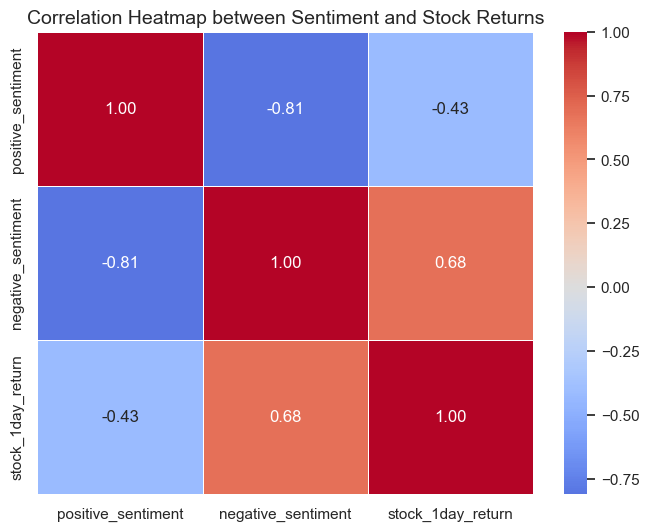

Correlation between positive sentiment and stock returns: -0.43
Correlation between negative sentiment and stock returns: 0.68


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrame with sentiment and stock return data
sentiment_data = {
    'positive_sentiment': [176, 155, 152, 162, 149, 166],
    'negative_sentiment': [23, 31, 31, 35, 36, 27],
    'stock_1day_return': [-2.45, -1.09, -0.89, 0.37, -0.28, 0.13],
    'quarter': ['Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024', 'Q1 2025', 'Q2 2025'],
    'year': [2024, 2024, 2024, 2024, 2025, 2025],
}

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_data)

# Calculate correlation matrix
correlation_matrix = sentiment_df[['positive_sentiment', 'negative_sentiment', 'stock_1day_return']].corr()

# Set up the plot style
sns.set(style="whitegrid")

# Create the heatmap to show correlation between the variables
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')

# Set title
plt.title('Correlation Heatmap between Sentiment and Stock Returns', fontsize=14)

# Show the plot
plt.show()

# Print the correlation values for clarity
print(f"Correlation between positive sentiment and stock returns: {correlation_matrix.iloc[0, 2]:.2f}")
print(f"Correlation between negative sentiment and stock returns: {correlation_matrix.iloc[1, 2]:.2f}")